# Parallelised Pitch Control Video Generation: Liverpool Challenge
### Surya K

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
from tqdm import tqdm
from joblib import Parallel, delayed
import glob
import os
import os.path
import re

sys.path.append('./LaurieOnTracking')
import Metrica_Viz as mviz
import Metrica_IO as mio
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc

sys.path.append('./lastrow_to_fot/lastrow_to_friendsoftracking')
import lastrow_to_friendsoftracking as lrfot

from pitch_control_helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
lastrow_DIR = os.getcwd()
last_row = pd.read_csv(lastrow_DIR + '/Last-Row/datasets/positional_data/liverpool_2019.csv', index_col=('play', 'frame'))

## Convert to Friends of Tracking wide format

In [10]:
data_attack, data_defence = lrfot.lastrow_to_friendsoftracking(last_row)
data_attack, data_defence = lrfot.lastrow_to_metric_coordinates(data_attack), lrfot.lastrow_to_metric_coordinates(data_defence)
data_attack, data_defence = lrfot.lastrow_to_single_playing_direction(data_attack, data_defence)

## Overview of Goals in the Dataset

In [11]:
last_row.index.get_level_values('play').unique()

goal_numbering = {}
for idx, play in enumerate(last_row.index.get_level_values('play').unique()):
    goal_numbering[play] = idx+1
    
goal_numbering

{'Liverpool [3] - 0 Bournemouth': 1,
 'Bayern 0 - [1] Liverpool': 2,
 'Fulham 0 - [1] Liverpool': 3,
 'Southampton 1 - [2] Liverpool': 4,
 'Liverpool [2] - 0 Porto': 5,
 'Porto 0 - [2] Liverpool': 6,
 'Liverpool [4] - 0 Barcelona': 7,
 'Liverpool [1] - 0 Wolves': 8,
 'Liverpool [3] - 0 Norwich': 9,
 'Liverpool [2] - 1 Chelsea': 10,
 'Liverpool [2] - 1 Newcastle': 11,
 'Liverpool [2] - 0 Salzburg': 12,
 'Genk 0 - [3] Liverpool': 13,
 'Liverpool [2] - 0 Man City': 14,
 'Liverpool [1] - 0 Everton': 15,
 'Liverpool [2] - 0 Everton': 16,
 'Bournemouth 0 - 3 Liverpool': 17,
 'Liverpool [1] - 0 Watford': 18,
 'Leicester 0 - [3] Liverpool': 19}

In [20]:
def generate_lvp_pc_time_pllel(frame):
    '''
    Main p'llel func that takes generates the pitch control grid surface, 
    using Laurie Shaw's Pitch Control model, LaurieOnTracking
    
    Creates: .npy files in a folder in the current directory. 'play_{play_number}/'
    We do this so the pitch control surfaces can be saved independent of the 
    notebook state, allowing us to tweak the visualisations without re-running the PC
    generation.
    
    :param frame: frame number of goal event
    :return: None
    '''
    fps = 20
    params=mpc.default_model_params(2)

    ball_pos = np.array([data_attack_play.loc[frame].ball_x, data_attack_play.loc[frame].ball_y])
   

    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )

    attacking_players = mpc.initialise_players(data_attack_play.loc[frame],'attack', params=params)
    defending_players = mpc.initialise_players(data_defence_play.loc[frame],'defense', params=params)

    for i in range( len(ygrid) ):
            for j in range( len(xgrid) ):
                target_position = np.array( [xgrid[j], ygrid[i]] )
                PPCFa[i,j],PPCFd[i,j] = mpc.calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_pos, params)
        # check probability sums within convergence
    
    # write each frame to a file
    np.save(f'play_{goal_numbering[play]}'+f'/{frame}', PPCFa)

## Video Generation
Change these values to generate videos for a different play.

Play names/numbers are stored in goal_numbering.

In [ ]:
# Change these values to generate videos for a different play
# Play names/numbers are stored in goal_numbering
play_num = '14'
play = 'Liverpool [2] - 0 Man City'

In [ ]:
# Run Pitch control generation

if not os.path.exists('play_'+play_num+'/'): os.makedirs('play_'+play_num+'/')
data_attack_play, data_defence_play, xgrid, ygrid = initialise_persistent_play_data(data_attack, data_defence, play)
Parallel(n_jobs=6)(delayed(generate_lvp_pc_time_pllel)(frame_num) for frame_num in tqdm(range(data_attack_play.index.max()+1)))

In [22]:
## Reconstruct PC surface of play from the files

recon_files = sorted([os.path.basename(file) for file in glob.glob('play_'+play_num+'/*')], key=lambda f: int(re.sub('\D', '', f)))
full_play_pc = []
for frame_file in recon_files:
    full_play_pc.append(np.load('play_'+play_num+'/'+frame_file))

full_play_pc[130]
clip = full_lvp_pc_video((data_attack_play, data_defence_play, xgrid, ygrid), full_play_pc)

if not os.path.exists('goals_pc/'): os.makedirs('goals_pc/')
clip.write_videofile('goals_pc/'+play_num+'_'+[team for team in sorted(play.split(), key=len)[-2:] if team!='Liverpool'][0]+'.mp4')


                                             
  7%|▋         | 12/167 [19:28<00:22,  6.94it/s]
                                             
t:   1%|          | 2/166 [00:00<00:09, 18.11it/s, now=None]

Moviepy - Building video goals_pc/14_City.mp4.
Moviepy - Writing video goals_pc/14_City.mp4



                                                              
                                             
  7%|▋         | 12/167 [19:44<00:22,  6.94it/s]
                                             
  7%|▋         | 12/167 [19:44<00:22,  6.94it/s]

Moviepy - Done !
Moviepy - video ready goals_pc/14_City.mp4


------------------------------------
## Quick Visualisations

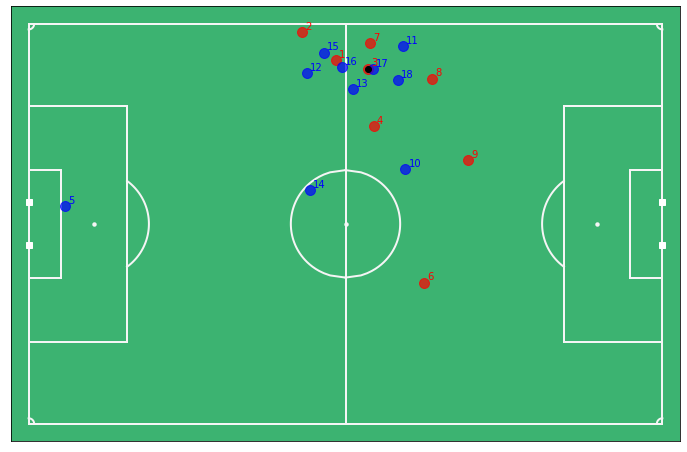

In [12]:
# Single Frame, green field
play = 'Liverpool [3] - 0 Bournemouth'
frame = 0
fig,ax = mviz.plot_frame( data_attack.loc[(play, frame)], data_defence.loc[(play, frame)],annotate=True )
plt.show()

Liverpool [3] - 0 Bournemouth


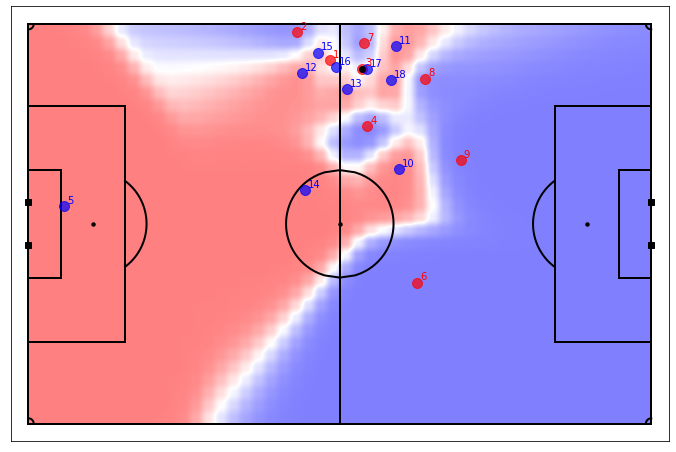

In [16]:
# Single Frame, Pitch Control surface
print(play)
persistent_play_data = initialise_persistent_play_data(data_attack, data_defence, play)
lol = generate_lvp_pc_time(*persistent_play_data, output_mode='plot')